Alex Medina | Problem Set #7

**Problem 1:**

- For a more satistical treatment, extract data from $261 < t< 262$.
- Normalize the stellar flux as $F_i / \bar{F}$ where $\bar{F}$ is the mean unobscured stellar flux, excluding the transit; making use of two-sigma clipping algorithm:
    - Computing the average and standard deviation $\bar{F}$ and $\sigma$ and excluding the transit by removing the points for which $ |F_i - \bar{F}/\sigma'| > 2$
- Use the following limb-darkening relation:

\begin{equation}
I(r) = 1 - (1 - \mu^2)
\end{equation}

where $\mu = \sqrt{1 - r^2}$.

- Guess that the parameters which fit this light curve: $p = 0.0775$, $a = 0.1$, $t_0 = 261.3$

- Compute $\chi^2$ for this choice of parameters:

\begin{equation}
\chi^2 = \sum_{i=1}^{N} \left( \frac{F_i - F(t_i; p, \tau, t_0)}{\sigma_{F, i}} \right)^2.
\end{equation}

In [1]:
#General imports
import math as m
import numpy as np
import matplotlib.pyplot as plt

#For this problem set
import pickle

#Loading up the file; as before
f97 = open("KOI97_01.p", "rb")
data97 = pickle.load(f97)
time0, flux0, flux_err0 = data97

In [2]:
#Extracting the section from t = 261 to 262
index = np.where((time0 > 261) & (time0 < 262))
time_obs = time0[index]
flux_obs = flux0[index]
flux_err_obs = flux_err0[index]

In [3]:
#Normalizing the flux with a two-sigma clipping algorithm
def clip_mean(x):
    for i in range(8):
        #x will be the flux
        #We want x where the flux F_i minus the mean flux F_mean is greater than 2 sigma
        x = x[np.where(abs(x - x.mean()) < 2 * x.std())]
    return x.mean()

normalize_flux = clip_mean(flux_obs)
print(normalize_flux)

106594.31


In [4]:
#Normalizing the flux
flux_obs_ratio = flux_obs/normalize_flux
flux_err_error = flux_err_obs/normalize_flux

In [5]:
#From pset 2, but with a more sophisticated apprach on limb darkening functions

def delta_fct(p, r, z):

    #At the ends of Simpson's rule, scalar values are fed in
    if np.isscalar(r):
        nr = 1
        r  = np.array([r])
    else:
        nr = len(r)
    
    #Mark unmodified elements
    result = np.zeros(nr) - 99
    
    #Where returns an array of indices satisfying the condition
    result[ np.where(r + z <= p)] = 1

    #Two conditions tested, and concatenated inside a list
    result[np.concatenate((np.where(r >= z + p)[0], np.where(r <= z - p)[0]))] = 0 
    
    #Zero protect the division by adding a very small number to it
    eps = 1e-14
    
    #Fill everything else
    ind = np.where(result == -99)[0]
    result[ind] = np.arccos((z**2 - p**2 + r[ind]**2) / (2 * z * r[ind] + eps)) / np.pi
    
    return result

#Limb darkening function from this pset introduction
def I(r):
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu)**0.5)

def numerator(r, p, z):
    return I(r) * (1 - delta_fct(p, r, abs(z))) * 2 * r

def denominator(r, p, z):
    return I(r) * 2 * r

In [12]:
#Finally defining the integration

#Instead of doing a numerical integral, just using built in python integrators to be quicker
from scipy.integrate import quad

#Similar to pset 3
def lc_calculation(t, p, t0, tau):
    zs = (t - t0)/tau
    flux_ratio = []
    for zval in zs:
        obscured_flux, _ = quad(numerator, 0.0, 1.0, epsrel=1e-06, args=(p,zval))
        unobscured_flux, _ = quad(denominator, 0.0, 1.0, epsrel=1e-06, args=(p,zval))
        flux_ratio.append(obscured_flux / unobscured_flux)

    return np.array(flux_ratio)

In [13]:
#Now executing for given parameters and chi-squared

p = 0.0775
tau = 0.1
t0 = 261.3

flux_theory_ratio = lc_calculation(time_obs, p, t0, tau)

In [8]:
def chi_squared(yobs, ymodel, ysigma):
    return np.sum(((yobs - ymodel) / ysigma)**2)

chi2 = chi_squared(flux_obs_ratio, flux_theory_ratio, flux_err_error)
print("chi-squared = ", chi2)

chi-squared =  1465.677378078874


**Problem 2:**

Is this a good fit?
- Plot data on top of each other.
- Compute how likely $\chi^2$ value is assuming errors normally distributed.
    - Discussed in theory from lecture.

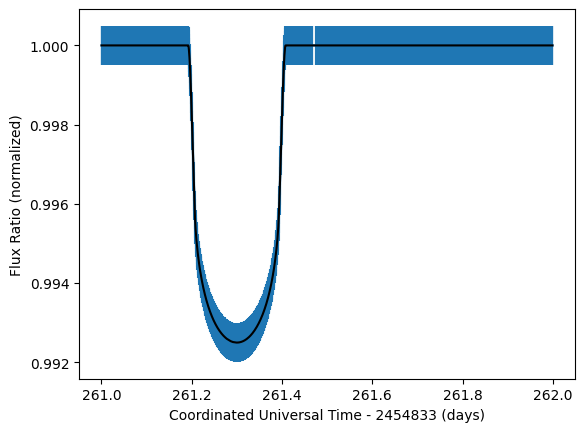

In [15]:
plt.errorbar(time_obs, flux_theory_ratio, yerr=flux_err_error, zorder=1)
plt.plot(time_obs, flux_theory_ratio,'k-')

plt.xlabel("Coordinated Universal Time - 2454833 (days)")
plt.ylabel("Flux Ratio (normalized)")
plt.show()

In [16]:
#To compute the probabilites assuming Gaussian errors, using incomplete gamma discussed in lecture
from scipy.special import gammaincc

nu = len(flux_obs_ratio) - 3
print("Degrees of freedom = ", nu)
print("probability of this chi-squared = ",gammaincc(nu/2, chi2/2))

Degrees of freedom =  1453
probability of this chi-squared =  0.4025130451845383


Looks like a good fit but overall isn't.